# Load and Functions

## Libraries and data set

In [82]:
# import os

# # Set the working directory
# os.chdir('/Users/hungduong/Documents/MSBA 2nd/IS 6812/home-credit-default-risk')

# # Verify the change
# print("Current Working Directory:", os.getcwd())

In [83]:
# importing packages for EDA
import pandas as pd
import numpy as np
import warnings

# Packages for plots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

#packages for preparing data
from sklearn.utils import resample
#from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from imblearn.under_sampling import RandomUnderSampler
import polars as pl


#packages for modelling
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
#from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.model_selection import RandomizedSearchCV
#from sklearn.model_selection import GridSearchCV

#from sklearn.metrics import roc_curve, auc
#import lightgbm as lgb

In [84]:
application_train_df = pd.read_csv("application_train.csv")
#application_test_df = pd.read_csv("application_test.csv")
#credit_card_df = pd.read_csv("credit_card_balance.csv")
#installment_df = pd.read_csv("installments_payments.csv")
previous_app_df = pd.read_csv("previous_application.csv")
#bureau_df = pd.read_csv('bureau.csv')

## Functions

Reduce memory load

In [85]:
# suppress warnings
warnings.filterwarnings('ignore')

# define the function for reducing memory usage when importing data
def reduce_memory_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

Factorized external sources

In [86]:
def factorize_EXT_SOURCE(df):
    bins = [-1, 0, 0.3, 0.6, 0.8, 1.0]  # Define bin edges
    labels = ['None', 'Very Poor', 'Average', 'Good', 'Excellent']  # Category labels

    # Replace NaN with -1
    for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
        df[col] = df[col].fillna(-1).astype('float32')

    # Binning into categories
    for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
        df[col + '_Category'] = pd.cut(df[col], bins=bins, labels=labels, right=True, include_lowest=True)

    # Dropping original EXT_SOURCE columns
    df.drop(columns=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], inplace=True)

    # Factorizing the categorical columns
    for col in ['EXT_SOURCE_1_Category', 'EXT_SOURCE_2_Category', 'EXT_SOURCE_3_Category']:
        df[col] = pd.factorize(df[col], sort=True)[0]

    print(f"Factorized Columns: {['EXT_SOURCE_1_Category', 'EXT_SOURCE_2_Category', 'EXT_SOURCE_3_Category']}")

    return df

Bin car ages

In [87]:
def bin_CAR_AGE(df):

    df["OWN_CAR_AGE"] = df["OWN_CAR_AGE"].astype("float32")

    # Apply pd.cut() after ensuring the correct dtype
    # Apply pd.cut(), making a new feature
    df["CAR_AGE_BIN"] = pd.cut(df["OWN_CAR_AGE"],
                                 labels=["new", "old", "quite old", "very old"],
                                 bins=[0, df["OWN_CAR_AGE"].quantile(0.25),
                                       df["OWN_CAR_AGE"].median(),
                                       df["OWN_CAR_AGE"].quantile(0.75),
                                       df["OWN_CAR_AGE"].max()])

    # For rows that were originally missing, assign 'none' explicitly
    df["CAR_AGE_BIN"] = df["CAR_AGE_BIN"].cat.add_categories("none")  # Add "none" as a category
    df["CAR_AGE_BIN"] = df["CAR_AGE_BIN"].fillna("none")

    # Show the result
    print(df[['OWN_CAR_AGE', 'CAR_AGE_BIN']])

    # factorize
    df['CAR_AGE_BIN'] = pd.Categorical(df['CAR_AGE_BIN'], categories=["none", "new", "old", "quite old", "very old"], 
                                                   ordered=True) #order of value matter

    df["CAR_AGE_BIN_Factorized"], _ = pd.factorize(df["CAR_AGE_BIN"])
    df.drop(columns=["CAR_AGE_BIN"], inplace=True)
    return df

Name contract types

In [88]:
def contract_type_factorized(df):
    df = df.copy()  # Optional: avoid modifying the original
    df['NAME_CONTRACT_TYPE'] = pd.Categorical(
        df['NAME_CONTRACT_TYPE'],
        categories=['Cash loans', 'Revolving loans'],
        ordered=True
    )
    df['NAME_CONTRACT_TYPE'] = df['NAME_CONTRACT_TYPE'].cat.codes.astype(int)
    return df

Occupation 

In [89]:
#Change the missing occupations to others
def fill_OCCUPATION_col(df):
    df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].fillna("Others")
    return df

Drop NA over 65%

In [90]:
# filtering the data that has missing values > 65%
def dropna_over65(df):
    missing_values = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (missing_values / len(df) * 100)

    missing_data_over_65 = missing_percent[missing_percent > 65]
    print(f'There are: {len(missing_data_over_65)} columns missing data over 65%')
    print(missing_data_over_65)

#dropping columns that have more than 65% null values
    df.drop(columns = missing_data_over_65.index, inplace=True)
    print('\n')
    print(f'Shape of the df after removing missing data over 65% : {df.shape}')
    return df

In [91]:
def factorize_cat_cols(df):
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        df[col] = pd.factorize(df[col])[0]
    return df

In [92]:
# Drop highly-correlated numerical variables
# Identify pairs of features with correlation above a threshold
def redundant_data(df):
    threshold = 0.8
    to_drop = []  # List to store columns to drop
    numeric_columns = df.select_dtypes(include=['number']).columns
    correlation_matrix = df[numeric_columns].corr()

# Looping through the correlation matrix to find highly correlated pairs
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                if colname not in to_drop:
                    to_drop.append(colname)

# Drop one column from each highly correlated pair
    to_drop = list(set(to_drop) & set(df.columns))

    # Drop columns
    df.drop(columns=to_drop, inplace=True)
    print(f"Dropped {len(to_drop)} redundant columns")
    print(f"The columns names that were dropped are :{to_drop}")
    print('\n')
    print(f"Shape of the dataset after removing multicolinearitly: {df.shape}")
    return df

In [93]:
def imputing_na(df):
    for col in df.columns:
        if not df[col].dtype == 'number':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
    print("Imputed all na values")
    return df

In [94]:
#fixing CNT_CHILDREN
# We can see some people have 19 children according to the dataset. This is statistically rare.
# For any records have have > 6 children, they will be imputed to 6 children.
def standardize_children_col(df):
    df['CNT_CHILDREN'] = np.where(df['CNT_CHILDREN'] > 6, 6, df['CNT_CHILDREN'])
    df['CNT_CHILDREN'].value_counts().sort_index(ascending=True)
    return df

Cross validation function

In [95]:
def cross_validate_model(df, target_col, num_folds, model_fn):
    """
    Perform k-fold cross-validation on a classification model.

    Parameters:
    - df (pd.DataFrame): The full dataset
    - target_col (str): Name of the target column
    - num_folds (int): Number of folds for cross-validation
    - model_fn (function): A function that returns an untrained model (e.g., lambda: LogisticRegression())

    Returns:
    - List of accuracy scores for each fold
    """
    X = df.drop(columns=[target_col])
    y = df[target_col]

    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = model_fn()
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        acc = accuracy_score(y_val, preds)
        scores.append(acc)
        print(f"Fold {fold + 1}: Accuracy = {acc:.4f}")

    print(f"\nAverage Accuracy: {np.mean(scores):.4f}")
    return scores

# Application data set

## Highview

In [96]:
pd.set_option('display.max_columns', None)  # Show all columns
application_train_df.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

The TARGET variable is imbalance:

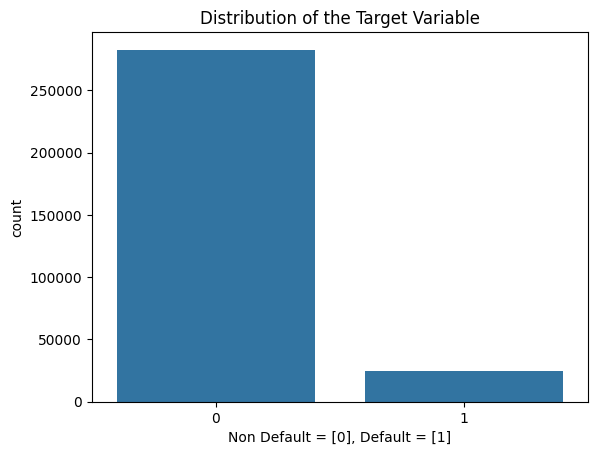

In [97]:
sns.countplot(x = application_train_df['TARGET'])
plt.title('Distribution of the Target Variable')
plt.xlabel('Non Default = [0], Default = [1]')
plt.show()

## Application data set clean, factorized, downsample

### clean/factorized

In [98]:
application_clean_df = application_train_df.copy()
reduce_memory_usage(application_clean_df)
factorize_EXT_SOURCE(application_clean_df)
bin_CAR_AGE(application_clean_df)
contract_type_factorized(application_clean_df)
fill_OCCUPATION_col(application_clean_df)
#dropna_over65(application_clean_df)

cat_cols_app = factorize_cat_cols(application_clean_df)

#redundant_data(application_clean_df)
imputing_na(application_clean_df)
standardize_children_col(application_clean_df)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Factorized Columns: ['EXT_SOURCE_1_Category', 'EXT_SOURCE_2_Category', 'EXT_SOURCE_3_Category']
        OWN_CAR_AGE CAR_AGE_BIN
0               NaN        none
1               NaN        none
2              26.0    very old
3               NaN        none
4               NaN        none
...             ...         ...
307506          NaN        none
307507          NaN        none
307508          NaN        none
307509          NaN        none
307510          NaN        none

[307511 rows x 2 columns]
Imputed all na values


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1_Category,EXT_SOURCE_2_Category,EXT_SOURCE_3_Category,CAR_AGE_BIN_Factorized
0,100002,1,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0,0,0,0,0,0.018799,-9461,-637,-3648.0,-2120,7.0,1,1,0,1,1,0,0,1.0,2,2,0,10,0,0,0,0,0,0,0,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.000000,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,0,0,0.014900,0,0,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,0
1,100003,0,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,1,1,1,1,0,0.003542,-16765,-1188,-1186.0,-291,7.0,1,1,0,1,1,0,1,2.0,1,1,1,11,0,0,0,0,0,0,1,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.000000,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,0,0,0.071411,1,0,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,0,0
2,100004,0,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0,0,0,0,0,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,0,1.0,2,2,1,9,0,0,0,0,0,0,2,0.082520,0.000000,0.987305,0.823242,0.000000,0.000000,0.137939,0.166748,0.208252,0.000000,0.050415,0.000000,0.000000,0.000000,0.083984,0.000000,0.987305,0.830078,0.000000,0.000000,0.137939,0.166748,0.208252,0.000000,0.055115,0.000000,0.0,0.000000,0.083313,0.000000,0.987305,0.825684,0.000000,0.000000,0.137939,0.166748,0.208252,0.000000,0.0

In [99]:
application_clean_df.info()
application_clean_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 123 entries, SK_ID_CURR to CAR_AGE_BIN_Factorized
dtypes: float16(57), float32(5), int16(2), int32(2), int64(20), int8(37)
memory usage: 100.6 MB


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1_Category,EXT_SOURCE_2_Category,EXT_SOURCE_3_Category,CAR_AGE_BIN_Factorized
0,100002,1,0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0,0,0,0,0,0.018799,-9461,-637,-3648.0,-2120,7.0,1,1,0,1,1,0,0,1.0,2,2,0,10,0,0,0,0,0,0,0,0.024704,0.036896,0.972168,0.619141,0.014297,0.000000,0.068970,0.083313,0.125000,0.036896,0.020203,0.018997,0.000000,0.000000,0.025208,0.038300,0.972168,0.634277,0.014397,0.000000,0.068970,0.083313,0.125000,0.037689,0.022003,0.019806,0.0,0.0,0.024994,0.036896,0.972168,0.624512,0.014397,0.000000,0.068970,0.083313,0.125000,0.037506,0.020493,0.019302,0.000000,0.000000,0,0,0.014900,0,0,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,0
1,100003,0,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,1,1,1,1,0,0.003542,-16765,-1188,-1186.0,-291,7.0,1,1,0,1,1,0,1,2.0,1,1,1,11,0,0,0,0,0,0,1,0.095886,0.052887,0.984863,0.795898,0.060486,0.080017,0.034485,0.291748,0.333252,0.013000,0.077271,0.054901,0.003901,0.009804,0.092407,0.053802,0.984863,0.804199,0.049713,0.080627,0.034485,0.291748,0.333252,0.012802,0.078979,0.055389,0.0,0.0,0.096802,0.052887,0.984863,0.798828,0.060791,0.080017,0.034485,0.291748,0.333252,0.013199,0.078674,0.055786,0.003901,0.010002,0,0,0.071411,1,0,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,0,0
2,100004,0,1,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0,0,0,0,0,0.010033,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,0,1.0,2,2,1,9,0,0,0,0,0,0,2,0.082520,0.000000,0.987305,0.823242,0.000000,0.000000,0.137939,0.166748,0.208252,0.000000,0.050415,0.000000,0.000000,0.000000,0.083984,0.000000,0.987305,0.830078,0.000000,0.000000,0.137939,0.166748,0.208252,0.000000,0.055115,0.000000,0.0,0.0,0.083313,0.000000,0.987305,0.825684,0.000000,0.000000,0.137939,0.166748,0.208252,0.000000,0.051300,0.000000,

### downsample

In [100]:
# Separate majority and minority classes
majority = application_clean_df[application_clean_df['TARGET'] == 0]
minority = application_clean_df[application_clean_df['TARGET'] == 1]

# Downsample majority class
majority_downsampled = resample(majority,
                                replace=False,    # no replacement
                                n_samples=len(minority),  # match minority class size
                                random_state=42)

# Combine back
application_clean_downsample = pd.concat([majority_downsampled, minority])


In [101]:
#Check if there are any columns with missing value
pd.set_option('display.max_rows', None)
print(application_clean_downsample.isna().sum() == 0) #True mean no missing

#application_clean_downsample
application_clean_downsample['TARGET'].value_counts()

#Count num rows
application_clean_downsample.shape[0]


pd.reset_option('display.max_rows')

SK_ID_CURR                      True
TARGET                          True
NAME_CONTRACT_TYPE              True
CODE_GENDER                     True
FLAG_OWN_CAR                    True
FLAG_OWN_REALTY                 True
CNT_CHILDREN                    True
AMT_INCOME_TOTAL                True
AMT_CREDIT                      True
AMT_ANNUITY                     True
AMT_GOODS_PRICE                 True
NAME_TYPE_SUITE                 True
NAME_INCOME_TYPE                True
NAME_EDUCATION_TYPE             True
NAME_FAMILY_STATUS              True
NAME_HOUSING_TYPE               True
REGION_POPULATION_RELATIVE      True
DAYS_BIRTH                      True
DAYS_EMPLOYED                   True
DAYS_REGISTRATION               True
DAYS_ID_PUBLISH                 True
OWN_CAR_AGE                     True
FLAG_MOBIL                      True
FLAG_EMP_PHONE                  True
FLAG_WORK_PHONE                 True
FLAG_CONT_MOBILE                True
FLAG_PHONE                      True
F

## Modeling

#### Splitting

In [102]:
#Split the data
x_train, x_test, y_train, y_test = train_test_split(application_clean_downsample.drop('TARGET', axis=1),
                                                    application_clean_downsample['TARGET'], 
                                                    test_size=0.2, 
                                                    random_state=42)

### Fitting a logistic model

In [103]:
logistic_model = LogisticRegression(max_iter=5000)
logistic_model.fit(x_train, y_train)

LogisticRegression(max_iter=5000)

In [104]:
logistic_model.predict(x_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int8)

How good is the simple logistic model?

In [105]:
print("Accuracy of the logistic model is: ",round(accuracy_score(y_test,logistic_model.predict(x_test)),5))

Accuracy of the logistic model is:  0.60181


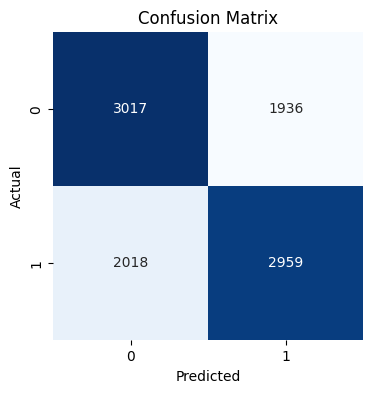

In [106]:
import seaborn as sns

log_cm = confusion_matrix(y_test, logistic_model.predict(x_test))
plt.figure(figsize=(4, 4))
sns.heatmap(log_cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Test other possible models 

In [107]:
#Random forest model
cross_validate_model(application_clean_downsample, 'TARGET', 5, RandomForestClassifier)

Fold 1: Accuracy = 0.6588
Fold 2: Accuracy = 0.6657
Fold 3: Accuracy = 0.6597
Fold 4: Accuracy = 0.6748
Fold 5: Accuracy = 0.6608

Average Accuracy: 0.6640


[0.6588116817724069,
 0.6656596173212488,
 0.659718026183283,
 0.6748237663645519,
 0.6608257804632427]

In [108]:
#Logistic regression model again
cross_validate_model(application_clean_downsample, 'TARGET', 5, LogisticRegression)

Fold 1: Accuracy = 0.5792
Fold 2: Accuracy = 0.5830
Fold 3: Accuracy = 0.5717
Fold 4: Accuracy = 0.5850
Fold 5: Accuracy = 0.5818

Average Accuracy: 0.5801


[0.5791540785498489,
 0.582980866062437,
 0.5717019133937563,
 0.584994964753273,
 0.5817724068479355]

In [109]:
#Naive Baynes model
cross_validate_model(application_clean_downsample, 'TARGET', 5, GaussianNB)

Fold 1: Accuracy = 0.4982
Fold 2: Accuracy = 0.4979
Fold 3: Accuracy = 0.4983
Fold 4: Accuracy = 0.5821
Fold 5: Accuracy = 0.5021

Average Accuracy: 0.5157


[0.4981873111782477,
 0.49788519637462236,
 0.4982880161127895,
 0.5820745216515609,
 0.5021148036253776]

In [110]:
#XGBOOST model
cross_validate_model(application_clean_downsample, 'TARGET', 5, XGBClassifier)

Fold 1: Accuracy = 0.6699
Fold 2: Accuracy = 0.6687
Fold 3: Accuracy = 0.6700
Fold 4: Accuracy = 0.6762
Fold 5: Accuracy = 0.6715

Average Accuracy: 0.6713


[0.6698892245720041,
 0.6686807653575025,
 0.6699899295065458,
 0.676233635448137,
 0.6715005035246727]

In [111]:
#Light GBM
cross_validate_model(application_clean_downsample, 'TARGET', 5, model_fn=lambda: LGBMClassifier(verbose=-1))

Fold 1: Accuracy = 0.6803
Fold 2: Accuracy = 0.6817
Fold 3: Accuracy = 0.6764
Fold 4: Accuracy = 0.6848
Fold 5: Accuracy = 0.6833

Average Accuracy: 0.6813


[0.6802618328298087,
 0.6816717019133938,
 0.6764350453172205,
 0.6847935548841894,
 0.6832829808660624]

In [112]:
#Cat BOOST
cross_validate_model(application_clean_downsample, 'TARGET', 5, model_fn=lambda: CatBoostClassifier(verbose=0))

Fold 1: Accuracy = 0.6851
Fold 2: Accuracy = 0.6820
Fold 3: Accuracy = 0.6781
Fold 4: Accuracy = 0.6901
Fold 5: Accuracy = 0.6874

Average Accuracy: 0.6846


[0.6850956696878147,
 0.6819738167170192,
 0.678147029204431,
 0.6901309164149043,
 0.687411883182276]

# Previous application data set

## Highview

In [113]:
previous_app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [114]:
pd.set_option('display.max_columns', None)
previous_app_df.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


## Previous application functions

In [115]:
#bin numeric columns by none, min, 25,50,75,max & factorize with order
numeric_columns = ['AMT_ANNUITY','AMT_APPLICATION','AMT_CREDIT','AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'DAYS_DECISION', 'CNT_PAYMENT',
                   'DAYS_FIRST_DRAWING','DAYS_FIRST_DUE','DAYS_LAST_DUE_1ST_VERSION', 
                   'DAYS_LAST_DUE', 'DAYS_TERMINATION','SELLERPLACE_AREA']



#bin cat columns, NA with -1 and factorize no order
cat_noorder = ['WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START','FLAG_LAST_APPL_PER_CONTRACT',
               'NFLAG_LAST_APPL_IN_DAY','NAME_CASH_LOAN_PURPOSE', 'NAME_PAYMENT_TYPE','NAME_TYPE_SUITE','NAME_GOODS_CATEGORY',
               'NAME_SELLER_INDUSTRY','NAME_CLIENT_TYPE','CODE_REJECT_REASON','CHANNEL_TYPE',
              'NAME_PORTFOLIO', 'NFLAG_INSURED_ON_APPROVAL','NAME_CONTRACT_STATUS']    

#normalized, only fill missing with -1
fill_na_cols = ['RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED']

#This columns has already been captured by "NAME_PRODUCT_TYPE","NAME_CONTRACT_TYPE","NAME_YIELD_GROUP" combinations.
drop_columns = ["NAME_PRODUCT_TYPE","NAME_CONTRACT_TYPE","NAME_YIELD_GROUP","PRODUCT_COMBINATION","SK_ID_PREV"]

Function that fillna with -1, turn numeric columns into bins and factorize

In [116]:
def bin_factorize_numeric(df, columns, ordered=True):
    # Ensure the index is not float16
    if df.index.dtype == np.float16:
        df.index = df.index.astype("int64")

    for column in columns:
        col = df[column]

        # Ensure the column itself is not float16
        if col.dtype == np.float16:
            col = col.astype("float32")

        # Get bin edges
        bins = np.nanpercentile(col, [0, 25, 50, 75, 100])
        bins = np.unique(bins)

        # Perform binning (NaNs will stay NaN)
        binned = pd.cut(col, bins=bins, labels=False, include_lowest=True)

        # Convert to ordered categorical WITHOUT fillna
        df[column + "_binned"] = pd.Categorical(binned, ordered=ordered)

    # Drop original columns
    df.drop(columns=columns, inplace=True)

    return df

Function that turn categorical columns into factorized columns, fillna with -1, with or without order

In [117]:
def bin_factorize_cat(df, columns, ordered=True):
    for column in columns:
        col = df[column]

        # Temporarily fill NaNs with a unique placeholder
        placeholder = "__MISSING__"
        filled = col.fillna(placeholder)

        # Factorize filled values
        codes, uniques = pd.factorize(filled, sort=True)
        codes = pd.Series(codes, index=df.index)

        # Restore NaNs where the placeholder was used
        codes[filled == placeholder] = np.nan

        # Create a categorical column
        if ordered:
            categories = sorted(c for c in pd.unique(codes.dropna()))
            df[column + "_factored"] = pd.Categorical(codes, categories=categories, ordered=True)
        else:
            df[column + "_factored"] = pd.Categorical(codes, ordered=False)

    # Drop original columns
    df.drop(columns=columns, inplace=True)

    return df


## Clean/bin/factorize

In [118]:
previous_clean_df = previous_app_df.copy()
reduce_memory_usage(previous_clean_df)

bin_factorize_numeric(previous_clean_df, numeric_columns,ordered=True)
bin_factorize_cat(previous_clean_df, cat_noorder, ordered=False)

previous_clean_df[fill_na_cols] = previous_clean_df[fill_na_cols].fillna(-1)
previous_clean_df.drop(drop_columns, axis=1, inplace=True)

Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%


In [119]:
previous_clean_df.info()
previous_clean_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 32 columns):
 #   Column                                Non-Null Count    Dtype   
---  ------                                --------------    -----   
 0   SK_ID_CURR                            1670214 non-null  int32   
 1   RATE_DOWN_PAYMENT                     1670214 non-null  float16 
 2   RATE_INTEREST_PRIMARY                 1670214 non-null  float16 
 3   RATE_INTEREST_PRIVILEGED              1670214 non-null  float16 
 4   AMT_ANNUITY_binned                    1297979 non-null  category
 5   AMT_APPLICATION_binned                1670214 non-null  category
 6   AMT_CREDIT_binned                     1670213 non-null  category
 7   AMT_DOWN_PAYMENT_binned               774370 non-null   category
 8   AMT_GOODS_PRICE_binned                1284699 non-null  category
 9   DAYS_DECISION_binned                  1670214 non-null  category
 10  CNT_PAYMENT_binned                    1297

,SK_ID_CURR,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,AMT_ANNUITY_binned,AMT_APPLICATION_binned,AMT_CREDIT_binned,AMT_DOWN_PAYMENT_binned,AMT_GOODS_PRICE_binned,DAYS_DECISION_binned,CNT_PAYMENT_binned,DAYS_FIRST_DRAWING_binned,DAYS_FIRST_DUE_binned,DAYS_LAST_DUE_1ST_VERSION_binned,DAYS_LAST_DUE_binned,DAYS_TERMINATION_binned,SELLERPLACE_AREA_binned,WEEKDAY_APPR_PROCESS_START_factored,HOUR_APPR_PROCESS_START_factored,FLAG_LAST_APPL_PER_CONTRACT_factored,NFLAG_LAST_APPL_IN_DAY_factored,NAME_CASH_LOAN_PURPOSE_factored,NAME_PAYMENT_TYPE_factored,NAME_TYPE_SUITE_factored,NAME_GOODS_CATEGORY_factored,NAME_SELLER_INDUSTRY_factored,NAME_CLIENT_TYPE_factored,CODE_REJECT_REASON_factored,CHANNEL_TYPE_factored,NAME_PORTFOLIO_factored,NFLAG_INSURED_ON_APPROVAL_factored,NAME_CONTRACT_STATUS_factored
0,271877,0.0,0.182861,0.867188,0.0,0,0.0,0.0,0.0,3,1.0,0.0,3.0,3.0,3.0,3.0,1,2,15,1,1,23,0,NaN,19,2,2,7,4,3,0.0,0
1,108129,-1.0,-1.000000,-1.000000,3.0,3,3.0,NaN,3.0,3,3.0,0.0,3.0,3.0,3.0,3.0,0,4,11,1,1,24,3,6.0,27,10,2,7,3,2,1.0,0
2,122040,-1.0,-1.000000,-1.000000,2.0,2,2.0,NaN,2.0,2,1.0,0.0,3.0,2.0,3.0,3.0,0,5,11,1,1,24,0,5.0,27,10,2,7,5,2,1.0,0
3,176158,-1.0,-1.000000,-1.000000,3.0,3,3.0,NaN,3.0,2,1.0,0.0,2.0,2.0,2.0,2.0,0,1,7,1,1,24,0,NaN,27,10,2,7,5,2,1.0,0
4,202054,-1.0,-1.000000,-1.000000,3.0,3,3.0,NaN,3.0,1,2.0,NaN,NaN,NaN,NaN,NaN,0,4,9,1,1,20,0,NaN,27,10,2,1,5,2,NaN,2


## Aggregate before joining

We need to aggregate previous application before joining because for 1 unique SK_ID_CURR in application_clean_downsample could exist multiple in previous_clean_df, for instance:

In [120]:
#Only 1 SK_ID_CURR for application_clean_downsample
application_clean_downsample[application_clean_downsample['SK_ID_CURR']==333721]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1_Category,EXT_SOURCE_2_Category,EXT_SOURCE_3_Category,CAR_AGE_BIN_Factorized
201622,333721,0,0,0,1,0,1,292500.0,1102500.0,32364.0,1102500.0,1,0,0,1,0,0.018204,-11763,-688,-500.0,-3325,9.0,1,1,0,1,1,0,5,3.0,3,3,2,9,0,0,0,0,0,0,25,0.293701,0.199463,0.989258,0.823242,0.0,0.280029,0.241455,0.375,0.208252,0.134644,0.050415,0.064514,0.0,0.0028,0.299316,0.207031,0.989258,0.830078,0.0,0.281982,0.241455,0.375,0.208252,0.137695,0.055115,0.0672,0.0,0.003,0.296631,0.199463,0.989258,0.825684,0.0,0.280029,0.241455,0.375,0.208252,0.136963,0.0513,0.065613,0.0,0.002899,-1,0,0.237915,2,0,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,3,3,2


In [121]:
#There are 3 same SK_ID_CURR for previous_clean_df
previous_clean_df[previous_clean_df['SK_ID_CURR']==333721]

,SK_ID_CURR,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,AMT_ANNUITY_binned,AMT_APPLICATION_binned,AMT_CREDIT_binned,AMT_DOWN_PAYMENT_binned,AMT_GOODS_PRICE_binned,DAYS_DECISION_binned,CNT_PAYMENT_binned,DAYS_FIRST_DRAWING_binned,DAYS_FIRST_DUE_binned,DAYS_LAST_DUE_1ST_VERSION_binned,DAYS_LAST_DUE_binned,DAYS_TERMINATION_binned,SELLERPLACE_AREA_binned,WEEKDAY_APPR_PROCESS_START_factored,HOUR_APPR_PROCESS_START_factored,FLAG_LAST_APPL_PER_CONTRACT_factored,NFLAG_LAST_APPL_IN_DAY_factored,NAME_CASH_LOAN_PURPOSE_factored,NAME_PAYMENT_TYPE_factored,NAME_TYPE_SUITE_factored,NAME_GOODS_CATEGORY_factored,NAME_SELLER_INDUSTRY_factored,NAME_CLIENT_TYPE_factored,CODE_REJECT_REASON_factored,CHANNEL_TYPE_factored,NAME_PORTFOLIO_factored,NFLAG_INSURED_ON_APPROVAL_factored,NAME_CONTRACT_STATUS_factored
442577,333721,0.0,-1.0,-1.0,0.0,1,1.0,0.0,0.0,3,1.0,0.0,3.0,3.0,3.0,3.0,1,1,8,1,1,23,0,6.0,3,0,2,7,7,3,0.0,0
649020,333721,0.0,-1.0,-1.0,1.0,2,2.0,0.0,1.0,2,1.0,0.0,2.0,2.0,2.0,2.0,2,3,13,1,1,23,0,NaN,7,4,2,7,6,3,0.0,0
722915,333721,0.0,-1.0,-1.0,3.0,2,2.0,0.0,2.0,1,0.0,0.0,2.0,1.0,1.0,1.0,0,0,14,1,1,23,3,6.0,3,6,0,7,7,3,0.0,0


should we get the mode for all aggregation? (if every columns are factorized)

In [122]:
# Grouping key
group_key = 'SK_ID_CURR'

# Float columns (use mean)
rate_cols = ['RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED']

# Mode-aggregated columns (factored + binned)
mode_cols = [
    'AMT_ANNUITY_binned', 'AMT_APPLICATION_binned', 'AMT_CREDIT_binned',
    'AMT_DOWN_PAYMENT_binned', 'AMT_GOODS_PRICE_binned', 'DAYS_DECISION_binned',
    'CNT_PAYMENT_binned', 'DAYS_FIRST_DRAWING_binned', 'DAYS_FIRST_DUE_binned',
    'DAYS_LAST_DUE_1ST_VERSION_binned', 'DAYS_LAST_DUE_binned', 'DAYS_TERMINATION_binned',
    'SELLERPLACE_AREA_binned', 'WEEKDAY_APPR_PROCESS_START_factored',
    'HOUR_APPR_PROCESS_START_factored', 'FLAG_LAST_APPL_PER_CONTRACT_factored',
    'NFLAG_LAST_APPL_IN_DAY_factored', 'NAME_CASH_LOAN_PURPOSE_factored',
    'NAME_PAYMENT_TYPE_factored', 'NAME_TYPE_SUITE_factored', 'NAME_GOODS_CATEGORY_factored',
    'NAME_SELLER_INDUSTRY_factored', 'NAME_CLIENT_TYPE_factored',
    'CODE_REJECT_REASON_factored', 'CHANNEL_TYPE_factored', 'NAME_PORTFOLIO_factored',
    'NFLAG_INSURED_ON_APPROVAL_factored', 'NAME_CONTRACT_STATUS_factored'
]



In [123]:
# Mean for float rate columns
agg_dict = {col: 'mean' for col in rate_cols}

# Mode (value_counts().idxmax) for all other columns
agg_dict.update({col: lambda x: x.value_counts().index[0] for col in mode_cols})

In [124]:
#Aggregate here
aggregated_df = previous_clean_df.groupby(group_key, sort=False).agg(agg_dict).reset_index()

In [125]:
aggregated_df.info()
aggregated_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338857 entries, 0 to 338856
Data columns (total 32 columns):
 #   Column                                Non-Null Count   Dtype   
---  ------                                --------------   -----   
 0   SK_ID_CURR                            338857 non-null  int32   
 1   RATE_DOWN_PAYMENT                     338857 non-null  float32 
 2   RATE_INTEREST_PRIMARY                 338857 non-null  float32 
 3   RATE_INTEREST_PRIVILEGED              338857 non-null  float32 
 4   AMT_ANNUITY_binned                    338857 non-null  category
 5   AMT_APPLICATION_binned                338857 non-null  category
 6   AMT_CREDIT_binned                     338857 non-null  category
 7   AMT_DOWN_PAYMENT_binned               338857 non-null  category
 8   AMT_GOODS_PRICE_binned                338857 non-null  category
 9   DAYS_DECISION_binned                  338857 non-null  category
 10  CNT_PAYMENT_binned                    338857 non-null  c

,SK_ID_CURR,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,AMT_ANNUITY_binned,AMT_APPLICATION_binned,AMT_CREDIT_binned,AMT_DOWN_PAYMENT_binned,AMT_GOODS_PRICE_binned,DAYS_DECISION_binned,CNT_PAYMENT_binned,DAYS_FIRST_DRAWING_binned,DAYS_FIRST_DUE_binned,DAYS_LAST_DUE_1ST_VERSION_binned,DAYS_LAST_DUE_binned,DAYS_TERMINATION_binned,SELLERPLACE_AREA_binned,WEEKDAY_APPR_PROCESS_START_factored,HOUR_APPR_PROCESS_START_factored,FLAG_LAST_APPL_PER_CONTRACT_factored,NFLAG_LAST_APPL_IN_DAY_factored,NAME_CASH_LOAN_PURPOSE_factored,NAME_PAYMENT_TYPE_factored,NAME_TYPE_SUITE_factored,NAME_GOODS_CATEGORY_factored,NAME_SELLER_INDUSTRY_factored,NAME_CLIENT_TYPE_factored,CODE_REJECT_REASON_factored,CHANNEL_TYPE_factored,NAME_PORTFOLIO_factored,NFLAG_INSURED_ON_APPROVAL_factored,NAME_CONTRACT_STATUS_factored
0,271877,0.033773,-0.605713,-0.377604,0.0,0,0.0,0.0,0.0,2,1.0,0.0,2.0,2.0,2.0,2.0,1,2,18,1,1,23,0,0.0,4,5,2,7,4,3,0.0,0
1,108129,-0.407227,-1.000000,-1.000000,1.0,1,3.0,0.0,0.0,1,0.0,0.0,2.0,1.0,1.0,1.0,2,4,9,1,1,23,0,6.0,27,10,2,7,7,3,0.0,0
2,122040,-0.473831,-1.000000,-1.000000,0.0,2,2.0,0.0,1.0,0,1.0,0.0,0.0,0.0,0.0,3.0,0,5,11,1,1,24,3,5.0,27,4,2,7,5,0,1.0,0
3,176158,-0.517002,-1.000000,-1.000000,3.0,3,3.0,0.0,2.0,0,1.0,0.0,2.0,1.0,2.0,1.0,0,1,7,1,1,24,0,6.0,27,4,2,1,4,2,1.0,2
4,202054,-0.749572,-1.000000,-1.000000,3.0,3,0.0,0.0,3.0,3,2.0,0.0,3.0,2.0,1.0,1.0,0,4,12,1,1,24,3,1.0,27,10,2,7,5,2,0.0,2


In [126]:
#Check once more, should only have 1 result 
aggregated_df[aggregated_df['SK_ID_CURR']==333721]

,SK_ID_CURR,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,AMT_ANNUITY_binned,AMT_APPLICATION_binned,AMT_CREDIT_binned,AMT_DOWN_PAYMENT_binned,AMT_GOODS_PRICE_binned,DAYS_DECISION_binned,CNT_PAYMENT_binned,DAYS_FIRST_DRAWING_binned,DAYS_FIRST_DUE_binned,DAYS_LAST_DUE_1ST_VERSION_binned,DAYS_LAST_DUE_binned,DAYS_TERMINATION_binned,SELLERPLACE_AREA_binned,WEEKDAY_APPR_PROCESS_START_factored,HOUR_APPR_PROCESS_START_factored,FLAG_LAST_APPL_PER_CONTRACT_factored,NFLAG_LAST_APPL_IN_DAY_factored,NAME_CASH_LOAN_PURPOSE_factored,NAME_PAYMENT_TYPE_factored,NAME_TYPE_SUITE_factored,NAME_GOODS_CATEGORY_factored,NAME_SELLER_INDUSTRY_factored,NAME_CLIENT_TYPE_factored,CODE_REJECT_REASON_factored,CHANNEL_TYPE_factored,NAME_PORTFOLIO_factored,NFLAG_INSURED_ON_APPROVAL_factored,NAME_CONTRACT_STATUS_factored
221082,333721,0.0,-1.0,-1.0,0.0,2,2.0,0.0,0.0,1,1.0,0.0,2.0,1.0,1.0,1.0,0,0,13,1,1,23,0,6.0,3,0,2,7,7,3,0.0,0


# Joining aggregated_df and application_clean_downsample

## Merge and fillna for missing

In [127]:
#Temporarily no missing filling here

In [128]:
#Merge here
joined_df = application_clean_downsample.merge(aggregated_df, on='SK_ID_CURR', how='left')

In [129]:
joined_df.dtypes

SK_ID_CURR                               int32
TARGET                                    int8
NAME_CONTRACT_TYPE                       int64
CODE_GENDER                              int64
FLAG_OWN_CAR                             int64
                                        ...   
CODE_REJECT_REASON_factored           category
CHANNEL_TYPE_factored                 category
NAME_PORTFOLIO_factored               category
NFLAG_INSURED_ON_APPROVAL_factored    category
NAME_CONTRACT_STATUS_factored         category
Length: 154, dtype: object

In [130]:
#After joining some missing is expected
joined_df.isna().sum()

SK_ID_CURR                               0
TARGET                                   0
NAME_CONTRACT_TYPE                       0
CODE_GENDER                              0
FLAG_OWN_CAR                             0
                                      ... 
CODE_REJECT_REASON_factored           2315
CHANNEL_TYPE_factored                 2315
NAME_PORTFOLIO_factored               2315
NFLAG_INSURED_ON_APPROVAL_factored    2315
NAME_CONTRACT_STATUS_factored         2315
Length: 154, dtype: int64

In [131]:
#Missing?
joined_df.isna().sum().sum()

71765

## Joined_df highview

In [132]:
joined_df.info()
joined_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49650 entries, 0 to 49649
Columns: 154 entries, SK_ID_CURR to NAME_CONTRACT_STATUS_factored
dtypes: category(28), float16(57), float32(8), int16(2), int32(2), int64(20), int8(37)
memory usage: 18.1 MB


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1_Category,EXT_SOURCE_2_Category,EXT_SOURCE_3_Category,CAR_AGE_BIN_Factorized,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,AMT_ANNUITY_binned,AMT_APPLICATION_binned,AMT_CREDIT_binned,AMT_DOWN_PAYMENT_binned,AMT_GOODS_PRICE_binned,DAYS_DECISION_binned,CNT_PAYMENT_binned,DAYS_FIRST_DRAWING_binned,DAYS_FIRST_DUE_binned,DAYS_LAST_DUE_1ST_VERSION_binned,DAYS_LAST_DUE_binned,DAYS_TERMINATION_binned,SELLERPLACE_AREA_binned,WEEKDAY_APPR_PROCESS_START_factored,HOUR_APPR_PROCESS_START_factored,FLAG_LAST_APPL_PER_CONTRACT_factored,NFLAG_LAST_APPL_IN_DAY_factored,NAME_CASH_LOAN_PURPOSE_factored,NAME_PAYMENT_TYPE_factored,NAME_TYPE_SUITE_factored,NAME_GOODS_CATEGORY_factored,NAME_SELLER_INDUSTRY_factored,NAME_CLIENT_TYPE_factored,CODE_REJECT_REASON_factored,CHANNEL_TYPE_factored,NAME_PORTFOLIO_factored,NFLAG_INSURED_ON_APPROVAL_factored,NAME_CONTRACT_STATUS_factored
0,333721,0,0,0,1,0,1,292500.0,1102500.0,32364.0,1102500.0,1,0,0,1,0,0.018204,-11763,-688,-500.0,-3325,9.0,1,1,0,1,1,0,5,3.0,3,3,2,9,0,0,0,0,0,0,25,0.293701,0.199463,0.989258,0.823242,0.000000,0.280029,0.241455,0.375000,0.208252,0.134644,0.050415,0.064514,0.000000,0.0028,0.299316,0.207031,0.989258,0.830078,0.000000,0.281982,0.241455,0.375000,0.208252,0.137695,0.055115,0.067200,0.000000,0.003000,0.296631,0.199463,0.989258,0.825684,0.000000,0.280029,0.241455,0.375000,0.208252,0.136963,0.051300,0.065613,0.000000,0.002899,-1,0,0.237915,2,0,1.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0,3,3,2,0.000000,-1.0,-1.0,0.0,2,2.0,0.0,0.0,1,1.0,0.0,2.0,1.0,1.0,1.0,0,0,13,1,1,23,0,6.0,3,0,2,7,7,3,0.0,0
1,110157,0,1,1,0,0,0,270000.0,720000.0,36000.0,720000.0,0,3,2,1,0,0.046234,-23199,365243,-4264.0,-4151,7.0,1,0,0,1,0,0,4,2.0,1,1,5,10,0,0,0,0,0,0,5,0.076294,0.060303,0.977539,0.693848,0.030594,0.016006,0.12

In [133]:
#Test to make sure the length is the same, columns added
application_clean_downsample.shape

(49650, 123)

## Modeling

In [134]:
#Special function for catboost and xgb
# def prepare_df_copy(df, model_type='xgb'):
#     df_copy = df.copy()

#     if model_type == 'xgb':
#         for col in df_copy.select_dtypes(include='category').columns:
#             df_copy[col] = df_copy[col].cat.codes  # NaN → -1
#     elif model_type == 'catboost':
#         for col in df_copy.select_dtypes(include='category').columns:
#             df_copy[col] = df_copy[col].astype(str).replace(['nan', 'NaN', 'None'], 'NA')
#     else:
#         raise ValueError("model_type must be either 'xgb' or 'catboost'")

#     return df_copy

In [135]:
# cross_validate_model(joined_df, 'TARGET', 5, RandomForestClassifier)


In [136]:
# cross_validate_model(joined_df, 'TARGET', 5, LogisticRegression)


In [137]:
# cross_validate_model(joined_df, 'TARGET', 5, GaussianNB)


In [138]:
cross_validate_model(joined_df, 'TARGET', 5, model_fn=lambda: LGBMClassifier(verbose=-1))


Fold 1: Accuracy = 0.6860
Fold 2: Accuracy = 0.6865
Fold 3: Accuracy = 0.6822
Fold 4: Accuracy = 0.6921
Fold 5: Accuracy = 0.6887

Average Accuracy: 0.6871


[0.6860020140986909,
 0.6865055387713997,
 0.6821752265861027,
 0.6921450151057402,
 0.6887210473313192]

In [139]:
# cross_validate_model(
#     convert_categoricals_to_codes_copy(joined_df),
#     target_col='TARGET',
#     num_folds=5,
#     model_fn=lambda: XGBClassifier()
# )


In [140]:
# cross_validate_model(
#     prepare_df_copy(joined_df, model_type='catboost'),
#     target_col='TARGET',
#     num_folds=5,
#     model_fn=lambda: CatBoostClassifier(verbose=0)
# )

# KAGGLE submission

## Aplication test df preparation

In [141]:
application_test_df = pd.read_csv("application_test.csv")


In [142]:
application_test_df.shape[0]

48744

In [143]:
application_test_cleaned = application_test_df.copy()
reduce_memory_usage(application_test_cleaned)
factorize_EXT_SOURCE(application_test_cleaned)
bin_CAR_AGE(application_test_cleaned)
contract_type_factorized(application_test_cleaned)
fill_OCCUPATION_col(application_test_cleaned)
#dropna_over65(application_test_cleaned)

cat_cols_app = factorize_cat_cols(application_test_cleaned)

#redundant_data(application_test_cleaned)
imputing_na(application_test_cleaned)
standardize_children_col(application_test_cleaned)


Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Factorized Columns: ['EXT_SOURCE_1_Category', 'EXT_SOURCE_2_Category', 'EXT_SOURCE_3_Category']
       OWN_CAR_AGE CAR_AGE_BIN
0              NaN        none
1              NaN        none
2              5.0         old
3              NaN        none
4             16.0    very old
...            ...         ...
48739          NaN        none
48740          NaN        none
48741          4.0         new
48742          NaN        none
48743         22.0    very old

[48744 rows x 2 columns]
Imputed all na values


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1_Category,EXT_SOURCE_2_Category,EXT_SOURCE_3_Category,CAR_AGE_BIN_Factorized
0,100001,0,0,0,0,0,135000.0,568800.0,20560.5,450000.0,0,0,0,0,0,0.018845,-19241,-2329,-5168.0,-812,4.0,1,1,0,1,0,1,0,2.0,2,2,0,18,0,0,0,0,0,0,0,0.065979,0.058990,0.973145,0.823242,0.000000,0.000000,0.137939,0.125000,0.208252,0.000000,0.067200,0.050507,0.000000,0.000000,0.067200,0.061188,0.973145,0.830078,0.000000,0.000000,0.137939,0.125000,0.208252,0.000000,0.073486,0.052612,0.00000,0.000000,0.066589,0.058990,0.973145,0.825684,0.00000,0.000000,0.137939,0.125000,0.208252,0.000000,0.068420,0.051392,0.000000,0.000000,-1,0,0.039215,0,0,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,1,0
1,100005,0,1,0,0,0,99000.0,222768.0,17370.0,180000.0,0,0,1,0,0,0.035797,-18064,-4469,-9120.0,-1623,4.0,1,1,0,1,0,0,1,2.0,2,2,1,9,0,0,0,0,0,0,1,0.082520,0.000000,0.986816,0.823242,0.000000,0.000000,0.137939,0.166748,0.208252,0.000000,0.067200,0.000000,0.000000,0.000000,0.083984,0.000000,0.986816,0.830078,0.000000,0.000000,0.137939,0.166748,0.208252,0.000000,0.073486,0.000000,0.00000,0.000000,0.083313,0.000000,0.986816,0.825684,0.00000,0.000000,0.137939,0.166748,0.208252,0.000000,0.068420,0.000000,0.000000,0.000000,-1,-1,0.000000,-1,-1,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,2,1,2,0
2,100013,0,1,1,0,0,202500.0,663264.0,69777.0,630000.0,-1,0,0,0,0,0.019104,-20038,-4458,-2176.0,-3503,5.0,1,1,0,1,0,0,2,2.0,2,2,2,14,0,0,0,0,0,0,2,0.082520,0.000000,0.986816,0.823242,0.000000,0.000000,0.137939,0.166748,0.208252,0.000000,0.067200,0.000000,0.000000,0.000000,0.083984,0.000000,0.986816,0.830078,0.000000,0.000000,0.137939,0.166748,0.208252,0.000000,0.073486,0.000000,0.00000,0.000000,0.083313,0.000000,0.986816,0.825684,0.00000,0.000000,0.137939,0.166748,0.208252,0.000000,0.0

## Application only

### Logistic regression model

In [144]:
log_kaggle = np.round(logistic_model.predict_proba(application_test_cleaned)[:, 1],1)

In [145]:
log_kaggle

array([0.4, 0.5, 0.5, ..., 0.5, 0.4, 0.7])

In [146]:
#submission = pd.DataFrame({'SK_ID_CURR': application_test_df['SK_ID_CURR'],'TARGET': log_kaggle})
#submission.to_csv('submission.csv', index=False)

In [147]:
# log model score was 0.61

### Cat BOOST model

In [148]:
# Create the model
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=0)

# Fit the model
catboost_model.fit(x_train, y_train)

# Predict
catboost_predict = catboost_model.predict(x_test)

In [149]:
catboost_kaggle = np.round(catboost_model.predict_proba(application_test_cleaned)[:, 1],1)

In [150]:
catboost_kaggle

array([0.6, 0.5, 0.2, ..., 0.3, 0.5, 0.7])

Accuracy: 0.6860
Precision: 0.6891
Recall (TPR): 0.6805
F1 Score: 0.6848

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.69      4953
           1       0.69      0.68      0.68      4977

    accuracy                           0.69      9930
   macro avg       0.69      0.69      0.69      9930
weighted avg       0.69      0.69      0.69      9930



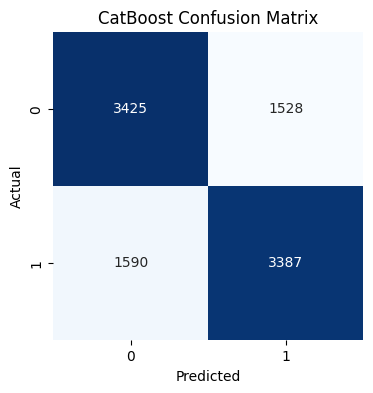

In [151]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

import matplotlib.pyplot as plt
import seaborn as sns

# Predictions and confusion matrix
catboost_predict = catboost_model.predict(x_test)
cat_cm = confusion_matrix(y_test, catboost_predict)

# Metrics
accuracy = accuracy_score(y_test, catboost_predict)
precision = precision_score(y_test, catboost_predict, average='binary')  # change to 'macro' or 'weighted' if multi-class
recall = recall_score(y_test, catboost_predict, average='binary')
f1 = f1_score(y_test, catboost_predict, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (TPR): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, catboost_predict))

# Confusion matrix heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(cat_cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.title('CatBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [152]:
#submission = pd.DataFrame({'SK_ID_CURR': application_test_df['SK_ID_CURR'],'TARGET': catboost_kaggle})
#submission.to_csv('submission.csv', index=False)

In [153]:
#The CatBOOST score is 0.69

## Application and previous application

### CatBoost again

CatBoost is a bit particular, since they don't like -1 values I didn't fillna for the application/previous/test application

#### Fit the model with joined_df (previous+application)

In [154]:
joined_df_copy = joined_df.copy()

Catboost don't like -1 values, we got alot of -1 from the data cleaning/ binning/ factorizing.
Change it to Missing, so catboost wouldn't yell at us

In [155]:
cat_cols = joined_df_copy.select_dtypes(include='category').columns

# Clean categorical columns in joined_df_copy
for col in cat_cols:
    joined_df_copy[col] = (
        joined_df_copy[col]
        .replace([-1, -1.0], 'Missing')   # convert numeric -1s
        .astype(str)                      # make everything string
        .replace('nan', 'Missing')        # convert 'nan' strings to 'Missing'
    )

In [156]:
# Split data set by features and target
x = joined_df_copy.drop(columns=['SK_ID_CURR', 'TARGET'])
y = joined_df_copy['TARGET']

# Identify categorical columns
cat_features = joined_df_copy.select_dtypes(include=['object', 'category']).columns.tolist()

# Initialize and fit model
application_previous_catmodel = CatBoostClassifier(verbose=0)  
application_previous_catmodel.fit(x, y, cat_features=cat_features)


#### Predict on new model with (previous+test application)

In [157]:
#Merging application test with previous application
test_joined_previous_df = application_test_cleaned.merge(aggregated_df, on='SK_ID_CURR', how='left')

In [158]:
#This took me too long to figure out, fitting didn't have ID, so should predict
x_test = test_joined_previous_df.drop(columns=['SK_ID_CURR'])

In [159]:
# Find all columns that will be treated as categorical
cat_cols = x_test.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    x_test[col] = (
        x_test[col]
        .replace([-1.0, -1], 'Missing')     # Replace actual float/int -1s
        .astype(str)                        # Now convert everything to string
        .replace(['nan'], 'Missing')        # Replace string "nan"
    )

In [160]:
catboost_previous_kaggle = np.round(application_previous_catmodel.predict_proba(x_test)[:, 1],1)
catboost_previous_kaggle

array([0.6, 0.5, 0.1, ..., 0.2, 0.4, 0.7])

In [161]:
# submission = pd.DataFrame({'SK_ID_CURR': test_joined_previous_df['SK_ID_CURR'],'TARGET': catboost_previous_kaggle})
# submission.to_csv('catboost_previous_submission.csv', index=False)

In [162]:
#Score improved! Passed the 0.70 threshold, kaggle score is 0.70509!!!!!